In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from crn_lyapunov.crn import ReactionNetwork, get_drift
from crn_lyapunov.smooth_lyapunov import SmoothLyapunov
from crn_lyapunov.training import Adversary, train_tight_sets

# Birth-death

In [2]:
torch.manual_seed(0)
from crn_lyapunov.crn import BirthDeath

net = BirthDeath(200, 1)

def quadratic_ref(x):
    return x**2

model, adv, history, history_dmax = train_tight_sets(
    net,
    quadratic_ref,
    1,
    probability=None, #1e-1,
    n_adv_samples=32,
    n_rand_samples=32,
    max_n=700,
    lr=1e-4,
    hidden_dim=128,
    steps_evolve=1,
    n_epochs=1000,
    d_max_weight=.1,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

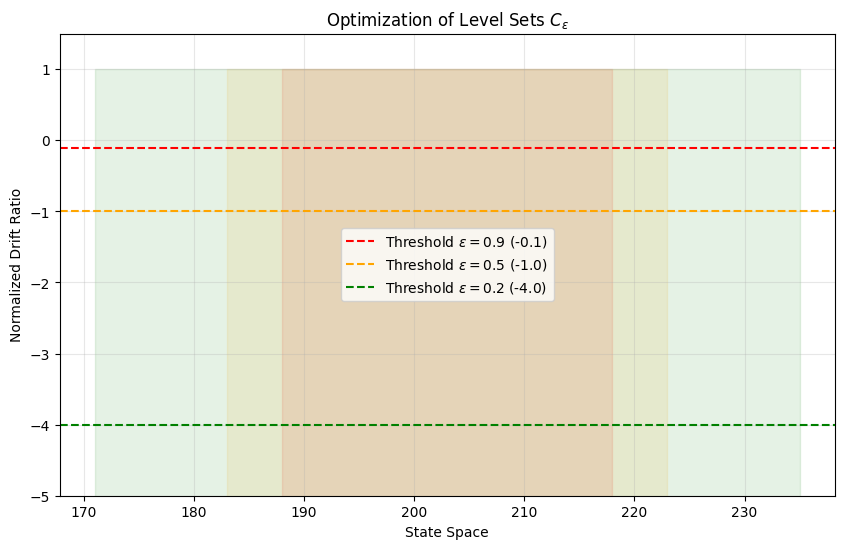

In [3]:
x_range = torch.arange(1000).float().view(-1, 1).detach()
with torch.no_grad():
    drift_vals = get_drift(model, net, x_range).detach().numpy()
    d_max = np.max(drift_vals)
    v_vals = model(x_range).numpy()
    alpha_vals = model._get_mixing_weight(quadratic_ref(x_range)).numpy()

epsilons = [0.9, 0.5, 0.2]
colors = ["red", "orange", "green"]

plt.figure(figsize=(10, 6))

for eps, col in zip(epsilons, colors):
    threshold = (eps - 1) / eps
    plt.axhline(
        threshold,
        linestyle="--",
        color=col,
        label=rf"Threshold $\epsilon={eps}$ ({threshold:.1f})",
    )

    mask = (drift_vals / d_max) > threshold
    if mask.any():
        # Find continuous regions (rough approximation for plot)
        plt.fill_between(
            x_range.flatten().detach(),
            -10,
            1,
            where=mask.flatten(),
            color=col,
            alpha=0.1,
        )

plt.ylim(-5, 1.5)
plt.title(r"Optimization of Level Sets $C_\epsilon$")
plt.xlabel("State Space")
plt.ylabel("Normalized Drift Ratio")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

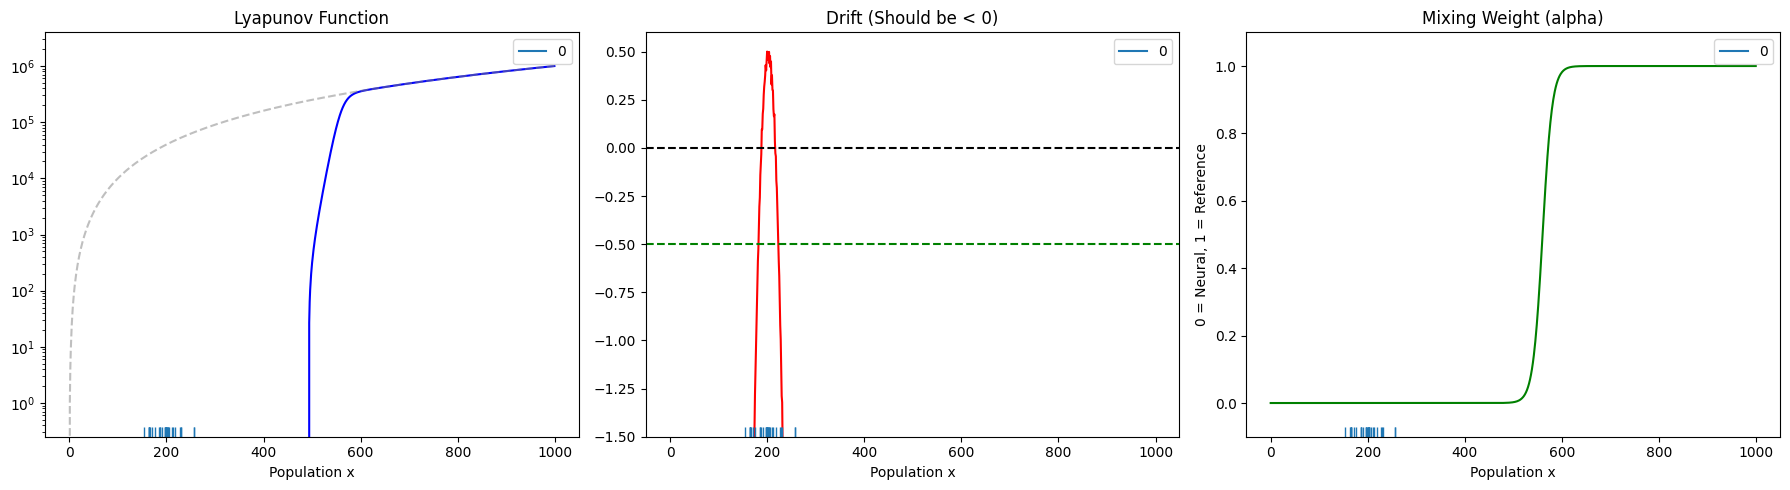

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x_range = x_range.detach()

# Plot V(x)
axes[0].plot(x_range, v_vals, label="Learned V(x)", color="blue")
axes[0].plot(
    x_range,
    quadratic_ref(x_range).numpy(),
    "--",
    label="Reference",
    color="gray",
    alpha=0.5,
)
axes[0].set_title("Lyapunov Function")
axes[0].set_xlabel("Population x")
axes[0].set_yscale("log")
axes[0].legend()

# Plot Drift
eps = 5e-1
axes[1].plot(x_range, eps * drift_vals / drift_vals.max(), color="red")
axes[1].axhline(0, color="k", linestyle="--")
axes[1].axhline(eps - 1, color="g", linestyle="--")
axes[1].set_title("Drift (Should be < 0)")
axes[1].set_xlabel("Population x")
axes[1].set_ylim(-1.5, eps + 0.1)  # Zoom in to see violations

# Plot Mixing Weight
axes[2].plot(x_range, alpha_vals, color="green")
axes[2].set_title("Mixing Weight (alpha)")
axes[2].set_xlabel("Population x")
axes[2].set_ylabel("0 = Neural, 1 = Reference")

for ax in axes:
    sns.rugplot(adv.population, ax=ax)

plt.tight_layout()
plt.show()

In [5]:
from scipy.stats import poisson
import torch
import numpy as np
import matplotlib.pyplot as plt

@torch.no_grad()
def plot_level_set_comparison_with_optimum(model, network, reference_fn, mu, gamma, x_max=600, min_level=-4):
    # 1. Setup State Space
    x_range = torch.arange(start=0, end=x_max, step=max(1, x_max // 1000)).float().view(-1, 1)
    x_np = x_range.numpy().flatten()
    
    # 2. Compute Drifts & Ratios
    # Augmented Model
    drift_aug = get_drift(model, network, x_range).detach().numpy().flatten()
    d_max_aug = np.max(drift_aug)
    ratio_aug = drift_aug / d_max_aug

    # Baseline Reference
    class RefWrapper(torch.nn.Module):
        def __init__(self, f):
            super().__init__()
            self.f = f
        def forward(self, x):
            return self.f(x)

    drift_ref = get_drift(RefWrapper(reference_fn), network, x_range).detach().numpy().flatten()
    d_max_ref = np.max(drift_ref)
    ratio_ref = drift_ref / d_max_ref

    # 3. Setup Mesh
    eps_vals = np.logspace(min_level, 0, 300)
    X, E = np.meshgrid(x_np, eps_vals)
    thresholds = 1.0 - (1.0 / E)

    # 4. Compute Sets
    C_aug = ratio_aug[None, :] > thresholds
    C_ref = ratio_ref[None, :] > thresholds

    # 5. Compute Poisson Optimum (Ground Truth)
    # The stationary distribution is Poisson(mu/gamma)
    lam = mu / gamma
    # For each eps, find the l_eps and h_eps such that mass is 1-eps
    l_eps = poisson.ppf(eps_vals / 2, lam)
    h_eps = poisson.ppf(1 - eps_vals / 2, lam)
    
    # Create mask: True if x is within [l_eps, h_eps]
    C_opt = (X >= l_eps[:, None]) & (X <= h_eps[:, None])

    # 6. Plotting
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))

    # Plot Reference (Blue) and Augmented (Red)
    ax1.pcolormesh(X, E, C_ref, cmap="Blues", shading="auto", alpha=0.4, label="Linear Ref")
    ax1.pcolormesh(X, E, C_aug, cmap="Reds", shading="auto", alpha=0.4, label="Augmented NN")
    
    # Plot Optimum (Green Outline or subtle fill)
    # We use a contour to show the boundary of the perfect set
    ax1.contour(X, E, C_opt, levels=[0.5], colors='green', linestyles='dashed', linewidths=1.5)

    # Styling
    ax1.set_yscale("log")
    ax1.set_ylabel(r"threshold $\epsilon$")
    ax1.set_xlabel("State Space (x)")
    ax1.set_title(f"Lyapunov Level Sets vs. Poisson Optimum ($\lambda={lam}$)")
    
    # Custom Legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='blue', lw=4, alpha=0.4),
                    Line2D([0], [0], color='red', lw=4, alpha=0.4),
                    Line2D([0], [0], color='green', lw=2, linestyle='--')]
    ax1.legend(custom_lines, ['Linear Reference Set', 'Augmented NN Set', r'Poisson Optimum (1-$\epsilon$ mass)'])

    ax1.grid(True, which="both", ls="-", alpha=0.1)
    plt.tight_layout()
    plt.show()

# Run with your parameters
plot_level_set_comparison_with_optimum(
    model, net, quadratic_ref, 
    mu=200.0, gamma=1.0, 
    min_level=-8, x_max=2000
)

<>:64: SyntaxWarning: invalid escape sequence '\l'
<>:64: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_367173/638766757.py:64: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_title(f"Lyapunov Level Sets vs. Poisson Optimum ($\lambda={lam}$)")
/tmp/ipykernel_367173/638766757.py:74: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipykernel_367173/638766757.py:64: SyntaxWarning: invalid escape sequence '\l'
  ax1.set_title(f"Lyapunov Level Sets vs. Poisson Optimum ($\lambda={lam}$)")

KeyboardInterrupt


KeyboardInterrupt



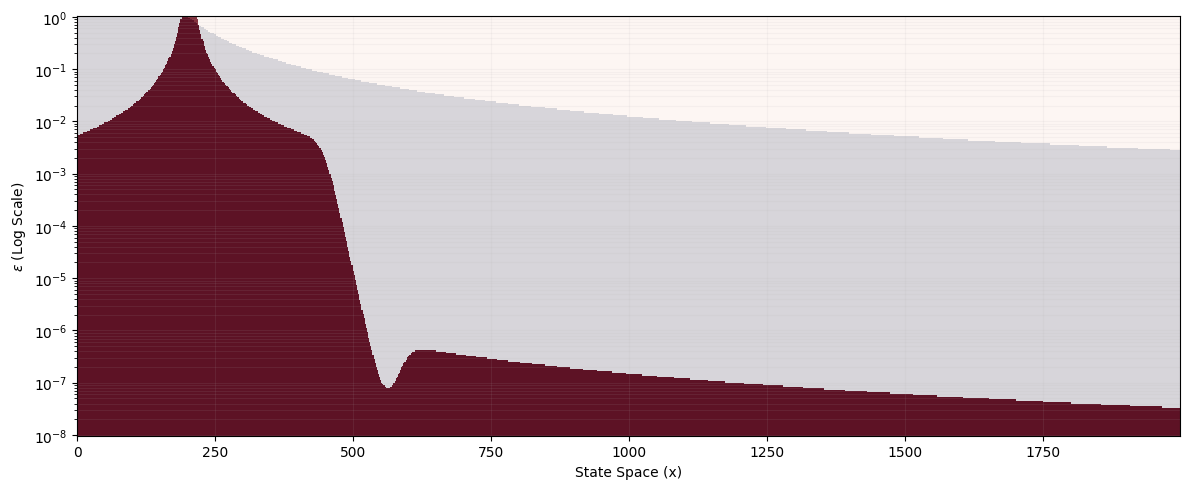

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


@torch.no_grad()
def plot_level_set_comparison(model, network, reference_fn, x_max=600, min_level=-4):
    x_range = (
        torch.arange(start=0, end=x_max, step=max(1, x_max // 1000)).float().view(-1, 1)
    )

    drift_aug = get_drift(model, network, x_range).detach().numpy().flatten()
    d_max_aug = np.max(drift_aug)
    ratio_aug = drift_aug / d_max_aug

    class RefWrapper(torch.nn.Module):
        def __init__(self, f):
            super().__init__()
            self.f = f

        def forward(self, x):
            return self.f(x)

    drift_ref = (
        get_drift(RefWrapper(reference_fn), network, x_range).detach().numpy().flatten()
    )
    d_max_ref = np.max(drift_ref)
    ratio_ref = drift_ref / d_max_ref

    eps_vals = np.logspace(min_level, 0, 300)
    X, E = np.meshgrid(x_range.numpy().flatten(), eps_vals)

    thresholds = 1.0 - (1.0 / E)

    C_aug = ratio_aug[None, :] > thresholds
    C_ref = ratio_ref[None, :] > thresholds

    # x_range

    fig, ax1 = plt.subplots(1, 1, figsize=(12, 5))

    im1 = ax1.pcolormesh(X, E, C_ref, cmap="Blues", shading="auto", alpha=0.8)
    im2 = ax1.pcolormesh(X, E, C_aug, cmap="Reds", shading="auto", alpha=0.8)
    ax1.set_yscale("log")
    ax1.set_ylabel(r"$\epsilon$ (Log Scale)")
    ax1.set_xlabel("State Space (x)")


    ax1.grid(True, which="both", ls="-", alpha=0.1)

    plt.tight_layout()
    plt.show()


# Execute the plot
plot_level_set_comparison(model, net, quadratic_ref, min_level=-8, x_max=2000)

# Schloegl

In [238]:
def solve_schlogl_params(x_low, x_high, c2=0.001):
    x1 = x_low
    x3 = x_high
    x2 = (x1 + x3) / 2 # Midpoint for symmetry
    
    S = x1 + x2 + x3
    P = (x1*x2) + (x2*x3) + (x3*x1)
    T = x1 * x2 * x3
    
    c1 = (c2/3) * S - c2
    c3 = (c2/6) * T
    c4 = (c2/6) * P - (c1/2) - (c2/3)
    
    return {"c1": c1, "c2": c2, "c3": c3, "c4": c4}

# Example: Modes at 20 and 80 (Distance of 60)
params = solve_schlogl_params(10, 100, c2 =0.006)
print(params)
# Output: {'c1': 0.294, 'c2': 0.006, 'c3': 80.0, 'c4': 6.451}

{'c1': 0.324, 'c2': 0.006, 'c3': 55.0, 'c4': 6.886}


Text(0.5, 1.0, 'Potential Wells (Minima = Modes)')

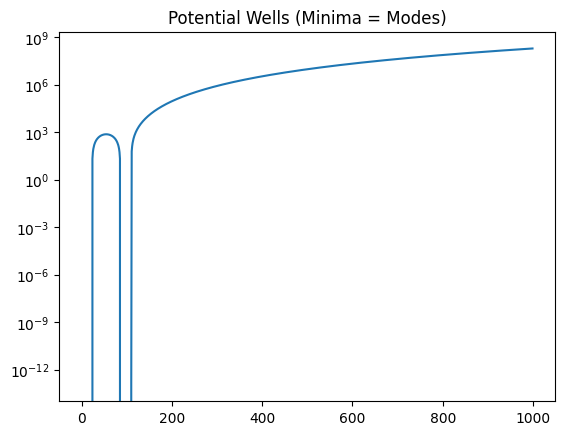

In [239]:
import numpy as np
import matplotlib.pyplot as plt

def get_potential(x_range, c1, c2, c3, c4):
    # Drift f(x)
    def f(x):
        return (c3 + 0.5*c1*x*(x-1)) - (c4*x + (c2/6)*x*(x-1)*(x-2))
    
    # Potential is -integral of f(x)
    # We can approximate it by cumulative sum
    drift_vals = [f(x) for x in x_range]
    potential = -np.cumsum(drift_vals)
    return potential

x = np.arange(0, 1000)
tune = 15
pot = get_potential(x, **params)
plt.plot(x, pot)
plt.yscale('log')
plt.title("Potential Wells (Minima = Modes)")

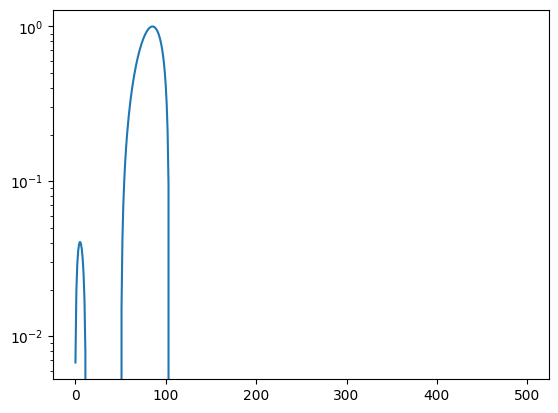

In [240]:
# --- Setup & Run ---
# parameters
#     c1=0.5
#     c2=0.333
#     c3=10
#     c4=1

# species
#     X: int

# reactions
#     2 X <-> 3 X @ mass_action(c1), mass_action(c2);
#     0 <-> X @ mass_action(c3), mass_action(c4);

# Standard Birth-Death Process
S_matrix = torch.tensor([[1.0], [-1.0], [1.0], [-1.0]])
# c1 = 0.5
# c2 = 0.333
# c3 = 10
# c4 = 1

# c1=0.3
# c2=0.01
# c3=10
# c4=3


# c1=0.25
# c2=0.007
# c3=10
# c4=3.7


def bd_propensities(x):
    return torch.cat(
        [
            torch.full((x.shape[0], 1), params['c3']),  # 0 -> X
            params['c4'] * x,  # X -> 0
            params['c1'] * x * (x - 1) / 2,  # 2 X -> 3 X
            params['c2'] * x * (x - 1) * (x - 2) / 6,
        ],
        dim=1,
    )


def quadratic_ref(x):
    return x**2


net = ReactionNetwork(S_matrix, bd_propensities)

x = torch.arange(500).reshape(-1, 1)
d = get_drift(quadratic_ref, net, x).flatten()
plt.plot(d / d.max())
plt.yscale('log')

In [243]:
model, adv, history, history_dmax = train_tight_sets(
    net,
    quadratic_ref,
    1,
    probability=None,
    n_adv_samples=32,
    n_rand_samples=64,
    max_n=500,
    lr=1e-4,
    hidden_dim=64,
    n_epochs=1000,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

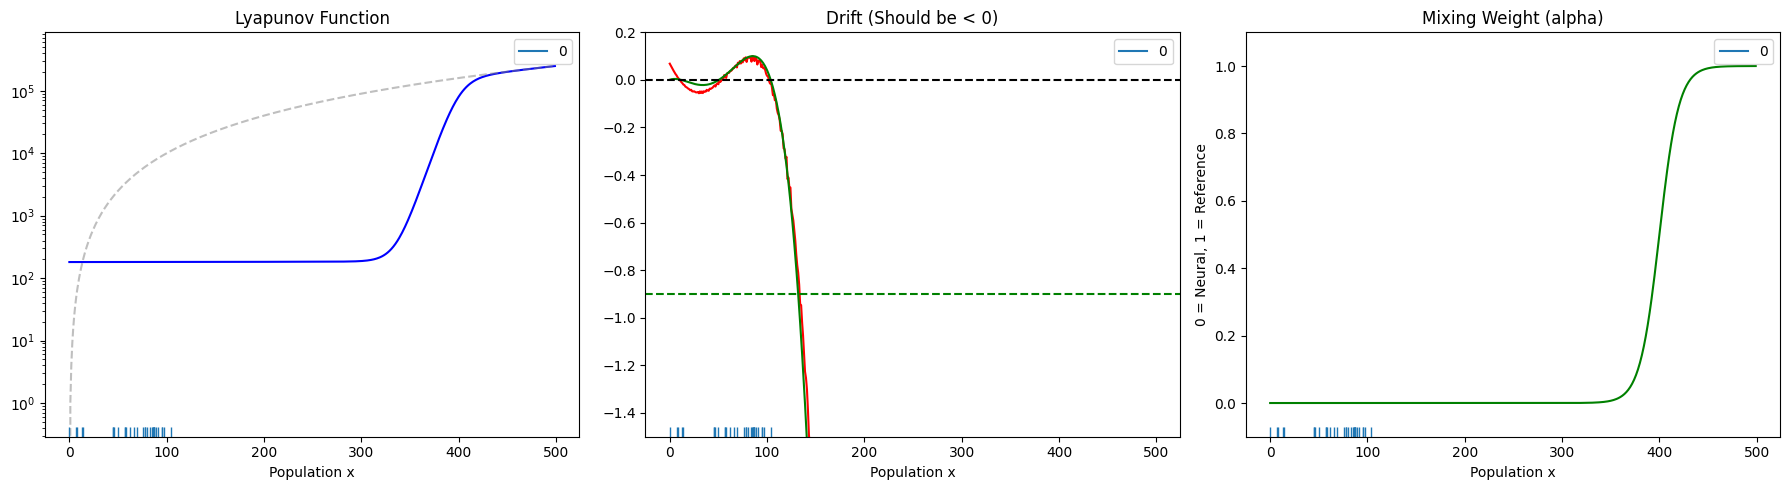

In [244]:
x_range = torch.arange(500).float().view(-1, 1).detach()
with torch.no_grad():
    drift_vals = get_drift(model, net, x_range).detach().numpy()
    drift_vals_ref = get_drift(model.reference_g, net, x_range).detach().numpy()
    d_max = np.max(drift_vals)
    v_vals = model(x_range).numpy()
    alpha_vals = model._get_mixing_weight(quadratic_ref(x_range)).numpy()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x_range = x_range.detach()

# Plot V(x)
axes[0].plot(x_range, v_vals, label="Learned V(x)", color="blue")
axes[0].plot(
    x_range,
    quadratic_ref(x_range).numpy(),
    "--",
    label="Reference",
    color="gray",
    alpha=0.5,
)
axes[0].set_title("Lyapunov Function")
axes[0].set_xlabel("Population x")
axes[0].set_yscale("log")
axes[0].legend()

# Plot Drift
eps = 1e-1
axes[1].plot(x_range, eps * drift_vals / drift_vals.max(), color="red", label='augmented')
axes[1].plot(x_range, eps * drift_vals_ref / drift_vals_ref.max(), color="green", label='reference')
axes[1].axhline(0, color="k", linestyle="--")
axes[1].axhline(eps - 1, color="g", linestyle="--")
axes[1].set_title("Drift (Should be < 0)")
axes[1].set_xlabel("Population x")
axes[1].set_ylim(-1.5, eps + 0.1)  # Zoom in to see violations
axes[1].legend()

# Plot Mixing Weight
axes[2].plot(x_range, alpha_vals, color="green")
axes[2].set_title("Mixing Weight (alpha)")
axes[2].set_xlabel("Population x")
axes[2].set_ylabel("0 = Neural, 1 = Reference")

for ax in axes:
    sns.rugplot(adv.population, ax=ax)

plt.tight_layout()
plt.show()

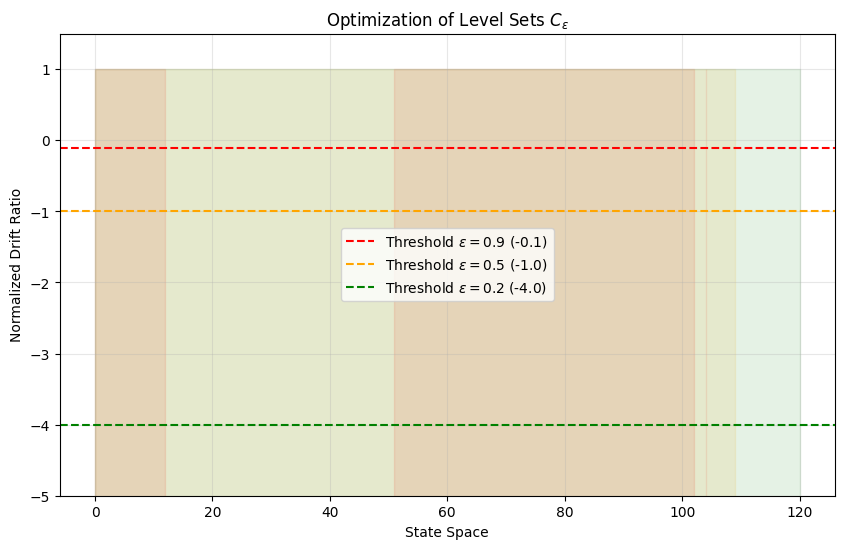

In [245]:
x_range = torch.arange(1000).float().view(-1, 1).detach()
with torch.no_grad():
    drift_vals = get_drift(model, net, x_range).detach().numpy()
    d_max = np.max(drift_vals)
    v_vals = model(x_range).numpy()
    alpha_vals = model._get_mixing_weight(quadratic_ref(x_range)).numpy()

epsilons = [0.9, 0.5, 0.2]
colors = ["red", "orange", "green"]

plt.figure(figsize=(10, 6))

for eps, col in zip(epsilons, colors):
    threshold = (eps - 1) / eps
    plt.axhline(
        threshold,
        linestyle="--",
        color=col,
        label=rf"Threshold $\epsilon={eps}$ ({threshold:.1f})",
    )

    mask = (drift_vals / d_max) > threshold
    if mask.any():
        # Find continuous regions (rough approximation for plot)
        plt.fill_between(
            x_range.flatten().detach(),
            -10,
            1,
            where=mask.flatten(),
            color=col,
            alpha=0.1,
        )

plt.ylim(-5, 1.5)
plt.title(r"Optimization of Level Sets $C_\epsilon$")
plt.xlabel("State Space")
plt.ylabel("Normalized Drift Ratio")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

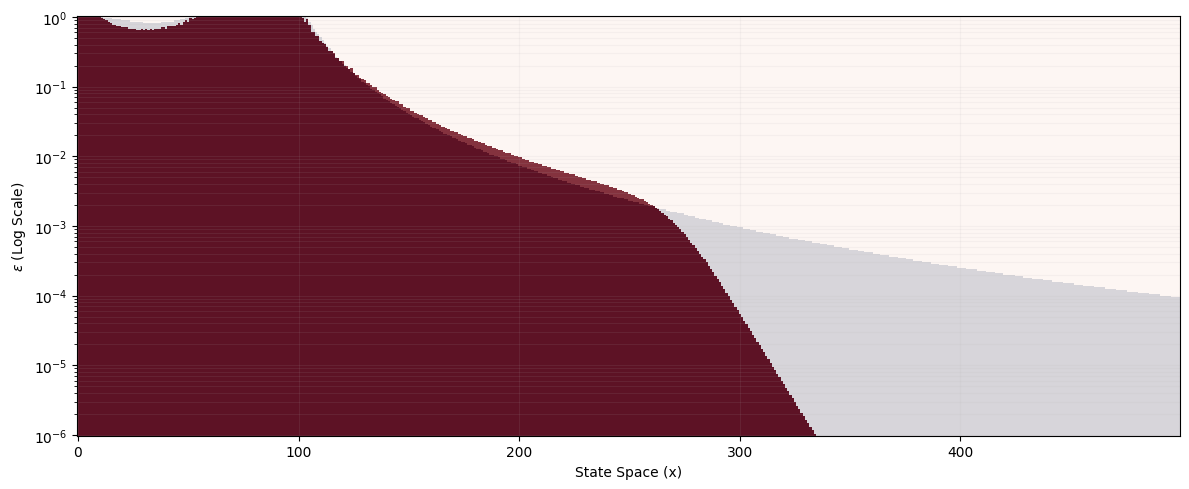

In [248]:
plot_level_set_comparison(model, net, quadratic_ref, x_max=500, min_level=-6)

# Parallel birth-death

In [75]:
class ParBD(ReactionNetwork):
    def __init__(self):
        S = torch.tensor(
            [
                [1.0, 0.0], 
                [-1.0, 0.0],
                [0.0, 1.0],
                [0.0, -1.0],
            ]
        )
        super().__init__(S, self._propensities)

        self.alpha = 1.0
        self.beta = 0.01

    def _propensities(self, x):
        X, Y = x[:, 0:1], x[:, 1:2]

        return torch.cat(
            [
                torch.full_like(X, self.alpha),
                self.beta * X,
                torch.full_like(Y, self.alpha),
                self.beta * Y,
            ],
            dim=1,
        )

def ref_g(x):
    X, Y = x[:, 0:1], x[:, 1:2]
    return (X - 0) ** 2 + (Y - 0) ** 2

net_parbd = ParBD()


model_parbd, adv_parbd, h_loss, h_dmax = train_tight_sets(
    net_parbd,
    ref_g,
    probability=None,
    n_species=2,
    steps_evolve=1,
    hidden_dim=512, # Smaller hidden_dim for fewer species
    n_adv_samples=2**8,
    n_rand_samples=2**10,
    max_n=3000,
    n_epochs=3000,
    gamma=0.5,
    lr=1e-4,
    d_max_weight=.01,
)

  0%|          | 0/3000 [00:00<?, ?it/s]

Optimus interruptus


In [68]:
num_points = 300
prey_range = torch.linspace(0, 300, num_points)
predator_range = torch.linspace(0, 300, num_points)

# Create a meshgrid
prey_mesh, predator_mesh = torch.meshgrid(prey_range, predator_range, indexing='xy')

# Flatten and combine points for drift calculation
x_grid = torch.stack([prey_mesh.flatten(), predator_mesh.flatten()], dim=1).to(device).float()

# Calculate drift over the grid
with torch.no_grad():
    grid_drift = get_drift(model_parbd, net_parbd, x_grid).cpu().numpy()
    grid_drift_ref = get_drift(ref_g, net_parbd, x_grid).cpu().numpy()

drift_heatmap_data = grid_drift.reshape(num_points, num_points) / grid_drift.max()
drift_heatmap_data_ref = grid_drift_ref.reshape(num_points, num_points) / grid_drift_ref.max()



for eps in np.logspace(-5, 0, 5)[::-1]:
    size_aug = np.count_nonzero(grid_drift / grid_drift.max() * eps > eps - 1)
    size_ref = np.count_nonzero(grid_drift_ref / grid_drift_ref.max() * eps > eps - 1)
    print(f"At eps={eps:2.2e} aug_size={size_aug:5d}  ref_size={size_ref:5d} improvement={size_ref/size_aug}")

At eps=1.00e+00 aug_size= 1446  ref_size=  624 improvement=0.4315352697095436
At eps=5.62e-02 aug_size= 5209  ref_size=11108 improvement=2.1324630447302746
At eps=3.16e-03 aug_size=11176  ref_size=88962 improvement=7.960093056549749
At eps=1.78e-04 aug_size=53838  ref_size=90000 improvement=1.6716817118020728
At eps=1.00e-05 aug_size=90000  ref_size=90000 improvement=1.0


# Toggle switch

In [76]:
class Toggle(ReactionNetwork):
    def __init__(self):
        S = torch.tensor(
            [
                [1.0, 0.0], 
                [-1.0, 0.0],
                [0.0, 1.0],
                [0.0, -1.0],
            ]
        )
        super().__init__(S, self._propensities)

        self.alpha = 10.0
        self.k = 1.5
        self.beta = 0.1

    def _propensities(self, x):
        X, Y = x[:, 0:1], x[:, 1:2]

        return torch.cat(
            [
                self.alpha / (1 + self.k * Y),
                self.beta * X,
                self.alpha / (1 + self.k * X),
                self.beta * Y,
            ],
            dim=1,
        )

def ref_g(x):
    X, Y = x[:, 0:1], x[:, 1:2]
    return (X - 0) ** 2 + (Y - 0) ** 2

net_toggle = Toggle()

model_toggle, adv_toggle, h_loss, h_dmax = train_tight_sets(
    net_toggle,
    ref_g,
    probability=None,
    n_species=2,
    steps_evolve=1,
    hidden_dim=512, # Smaller hidden_dim for fewer species
    n_adv_samples=2**8,
    n_rand_samples=2**10,
    max_n=200, 
    n_epochs=1000,
    gamma=0.0,
    lr=1e-4,
    d_max_weight=.0
)

  0%|          | 0/1000 [00:00<?, ?it/s]

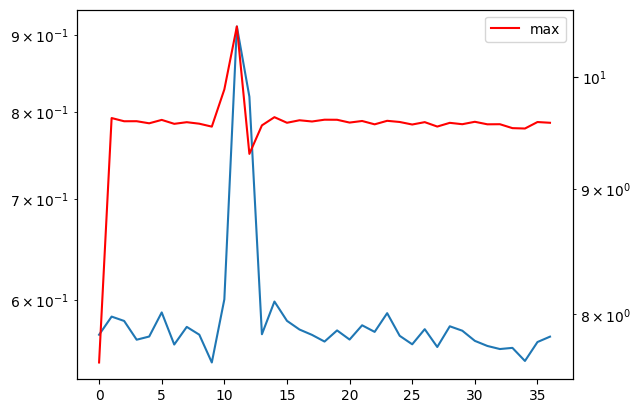

In [53]:
fig, ax = plt.subplots()
ax.plot(h_loss, label="loss")
tax = ax.twinx()
tax.plot(h_dmax, label="max", c="r")
tax.set_yscale('log')
ax.set_yscale('log')
plt.legend()

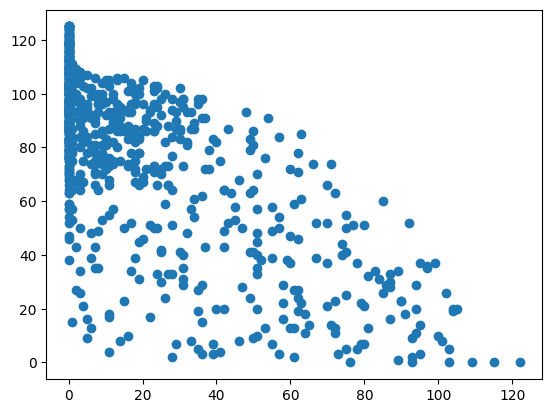

In [54]:
plt.scatter(*adv_toggle.population.detach().numpy().T)

In [66]:
num_points = 300
prey_range = torch.linspace(0, 300, num_points)
predator_range = torch.linspace(0, 300, num_points)

# Create a meshgrid
prey_mesh, predator_mesh = torch.meshgrid(prey_range, predator_range, indexing='xy')

# Flatten and combine points for drift calculation
x_grid = torch.stack([prey_mesh.flatten(), predator_mesh.flatten()], dim=1).to(device).float()

# Calculate drift over the grid
with torch.no_grad():
    grid_drift = get_drift(model_toggle, net_toggle, x_grid).cpu().numpy()
    grid_drift_ref = get_drift(ref_g, net_toggle, x_grid).cpu().numpy()

drift_heatmap_data = grid_drift.reshape(num_points, num_points) / grid_drift.max()
drift_heatmap_data_ref = grid_drift_ref.reshape(num_points, num_points) / grid_drift_ref.max()



for eps in np.logspace(-5, 0, 5)[::-1]:
    size_aug = np.count_nonzero(grid_drift / grid_drift.max() * eps > eps - 1)
    size_ref = np.count_nonzero(grid_drift_ref / grid_drift_ref.max() * eps > eps - 1)
    print(f"At eps={eps:2.2e} aug_size={size_aug:5d}  ref_size={size_ref:5d} improvement={size_ref/size_aug}")

At eps=1.00e+00 aug_size=  427  ref_size=  415 improvement=0.9718969555035128
At eps=5.62e-02 aug_size= 8964  ref_size=34486 improvement=3.847166443551986
At eps=3.16e-03 aug_size=13525  ref_size=90000 improvement=6.654343807763401
At eps=1.78e-04 aug_size=78716  ref_size=90000 improvement=1.14335078001931
At eps=1.00e-05 aug_size=90000  ref_size=90000 improvement=1.0


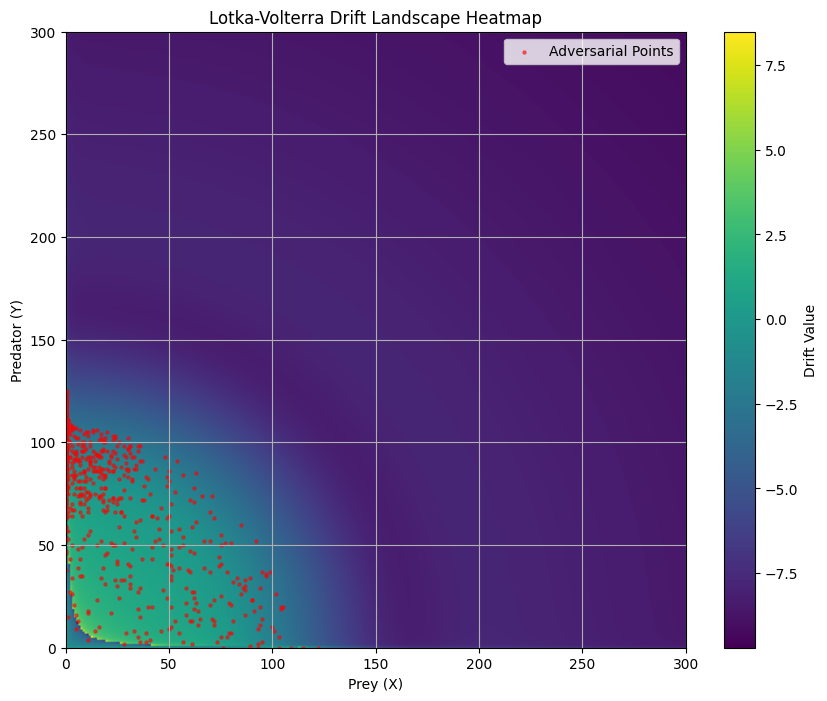

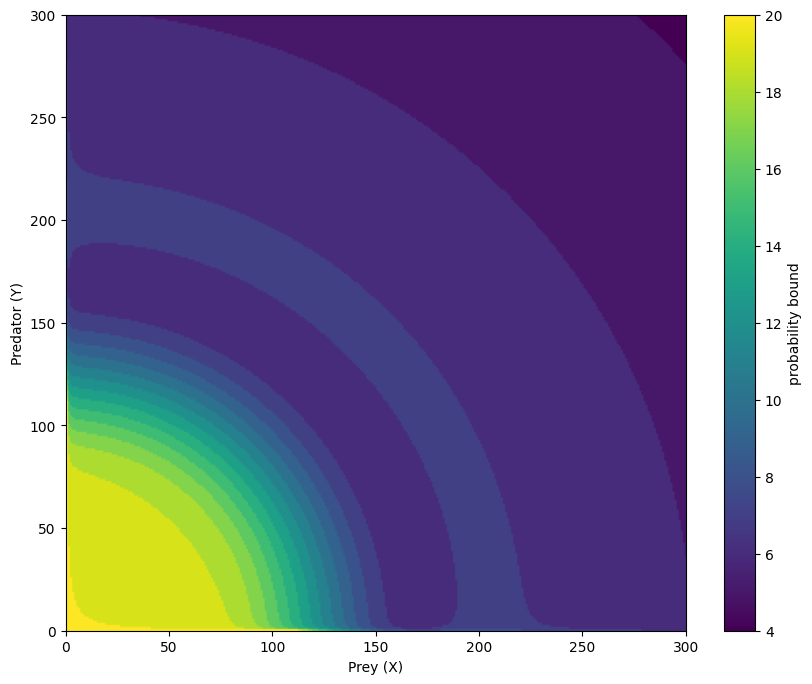

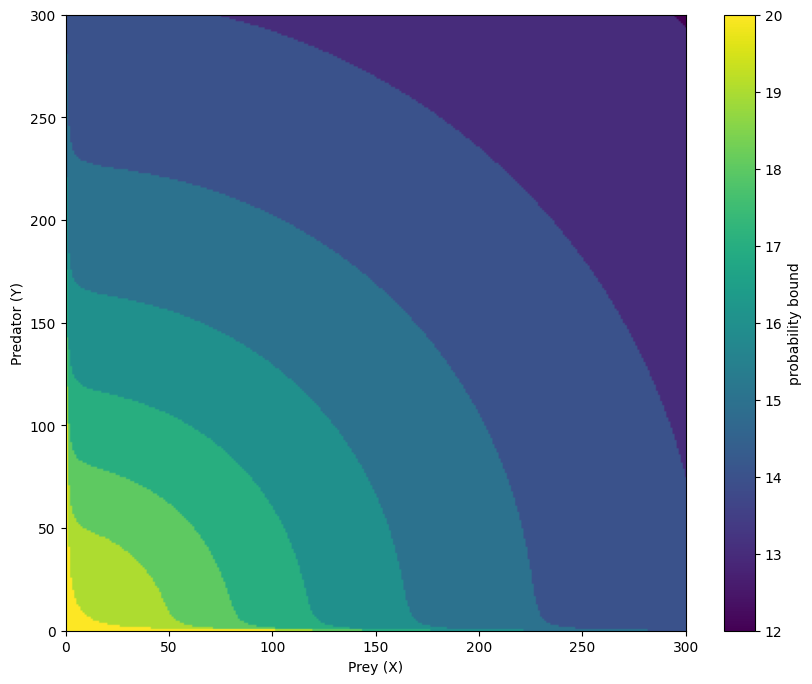

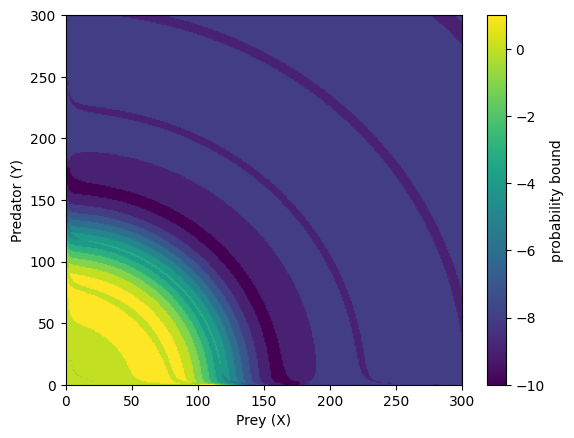

In [57]:
device = 'cpu'
# Define the grid for visualization
num_points = 300
prey_range = torch.linspace(0, 300, num_points)
predator_range = torch.linspace(0, 300, num_points)

# Create a meshgrid
prey_mesh, predator_mesh = torch.meshgrid(prey_range, predator_range, indexing='xy')

# Flatten and combine points for drift calculation
x_grid = torch.stack([prey_mesh.flatten(), predator_mesh.flatten()], dim=1).to(device).float()

# Calculate drift over the grid
with torch.no_grad():
    grid_drift = get_drift(model_toggle, net_toggle, x_grid).cpu().numpy()
    grid_drift_ref = get_drift(ref_g, net_toggle, x_grid).cpu().numpy()

# Reshape drift values back to grid format
drift_heatmap_data = grid_drift.reshape(num_points, num_points) / grid_drift.max()
drift_heatmap_data_ref = grid_drift_ref.reshape(num_points, num_points) / grid_drift_ref.max()

# Create the heatmap plot
plt.figure(figsize=(10, 8))
plt.imshow(
    np.sign(drift_heatmap_data.T) * np.log(np.abs(drift_heatmap_data.T)),
    origin='lower',
    extent=[prey_range.min(), prey_range.max(), predator_range.min(), predator_range.max()],
    cmap='viridis',
    aspect='auto'
)

plt.colorbar(label='Drift Value')
# Add the adversarial points on top for context
points_lv = adv_toggle.population.detach().cpu().numpy()
plt.scatter(points_lv[:, 0], points_lv[:, 1], c='red', s=5, alpha=0.5, label='Adversarial Points')

plt.xlabel('Prey (X)')
plt.ylabel('Predator (Y)')
plt.title('Lotka-Volterra Drift Landscape Heatmap')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
dist_contour = np.zeros_like(drift_heatmap_data.T)
for eps in np.logspace(-5, 0, 20):
    dist_contour += drift_heatmap_data.T * eps > eps - 1
plt.imshow(
    dist_contour.T,
    origin='lower',
    extent=[prey_range.min(), prey_range.max(), predator_range.min(), predator_range.max()],
    cmap='viridis',
    aspect='auto'
)
plt.xlabel('Prey (X)')
plt.ylabel('Predator (Y)')
plt.colorbar(label='probability bound')
plt.show()



plt.figure(figsize=(10, 8))
dist_contour_ref = np.zeros_like(drift_heatmap_data_ref.T)
for eps in np.logspace(-5, 0, 20):
    dist_contour_ref += drift_heatmap_data_ref.T * eps > eps - 1
plt.imshow(
    dist_contour_ref.T,
    origin='lower',
    extent=[prey_range.min(), prey_range.max(), predator_range.min(), predator_range.max()],
    cmap='viridis',
    aspect='auto'
)
plt.xlabel('Prey (X)')
plt.ylabel('Predator (Y)')
plt.colorbar(label='probability bound')
plt.show()


plt.imshow(
    dist_contour.T - dist_contour_ref.T,
    origin='lower',
    extent=[prey_range.min(), prey_range.max(), predator_range.min(), predator_range.max()],
    cmap='viridis',
    aspect='auto'
)
plt.xlabel('Prey (X)')
plt.ylabel('Predator (Y)')
plt.colorbar(label='probability bound')
plt.show()

# Lotka-Volterra

In [305]:
# parameters
#   alpha = 1.0
#   beta = 0.001
#   gamma = 10.0
#   eps = 0.01

# species X Y

# reactions
#   X -> 2 X @ alpha * X;
#   X + Y -> 2 Y @ beta * X * Y;
#   Y -> 0 @ gamma * Y;
#   0 -> X @ eps;
#   X -> Y @ eps * X;


class LotkaVolterra(ReactionNetwork):
    def __init__(self):
        # Species Order: [Prey, Predator]
        S = torch.tensor(
            [
                [1.0, 0.0],   # Prey birth: X -> 2X
                [-1.0, 1.0],  # Predation: X + Y -> 2Y (Prey decreases, Predator increases)
                [0.0, -1.0],  # Predator death: Y -> 0
                [1.0, 0.0],   # Prey materialization: 0 -> X
                [-1.0, 1.0],  # Prey conversion: X -> Y
                [-1.0, 0.0],  # 
            ]
        )
        super().__init__(S, self._propensities)

        self.alpha = 1.0
        self.beta = 0.001
        self.gamma = 10.0
        self.eps = 0.01
        self.delta = 1e-4

    def _propensities(self, x):
        prey, predator = x[:, 0:1], x[:, 1:2]

        return torch.cat(
            [
                self.alpha * prey,               # Prey birth
                self.beta * prey * predator,     # Predation
                self.gamma * predator,           # Predator death
                torch.full_like(prey, self.eps), # Prey materialization
                self.eps * prey,                 # Prey-predator conversion
                self.delta * prey * (prey - 1),  # 2X -> X (The fix)
            ],
            dim=1,
        )

def centered_reference_g(x):
    x_star, y_star = 10000.0, 1000.0
    val = ((x[:, 0:1] - x_star)/x_star)**2 + ((x[:, 1:2] - y_star)/y_star)**2
    return val

net_lv = LotkaVolterra()

model_lv, adv_lv, h_loss_lv, h_dmax_lv = train_tight_sets(
    net_lv,
    centered_reference_g,
    probability=None,
    n_species=2,
    steps_evolve=1,
    hidden_dim=512, # Smaller hidden_dim for fewer species
    n_adv_samples=2**8,
    n_rand_samples=2**11,
    max_n=30_000, 
    n_epochs=1000,
    gamma=0.8,
    lr=1e-4,
)


--- Lotka-Volterra Model ---
Starting training for Lotka-Volterra...


  0%|          | 0/1000 [00:00<?, ?it/s]

Optimus interruptus


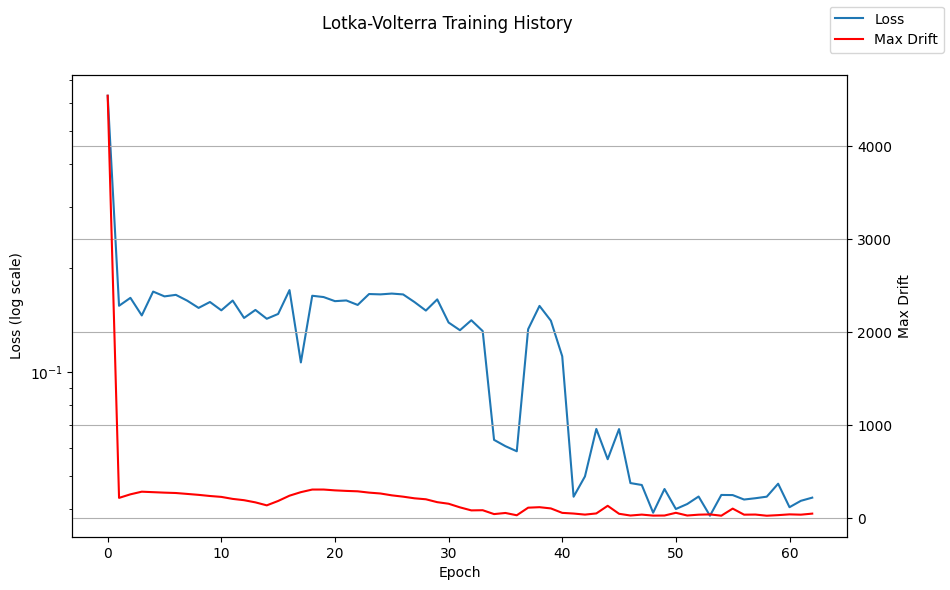

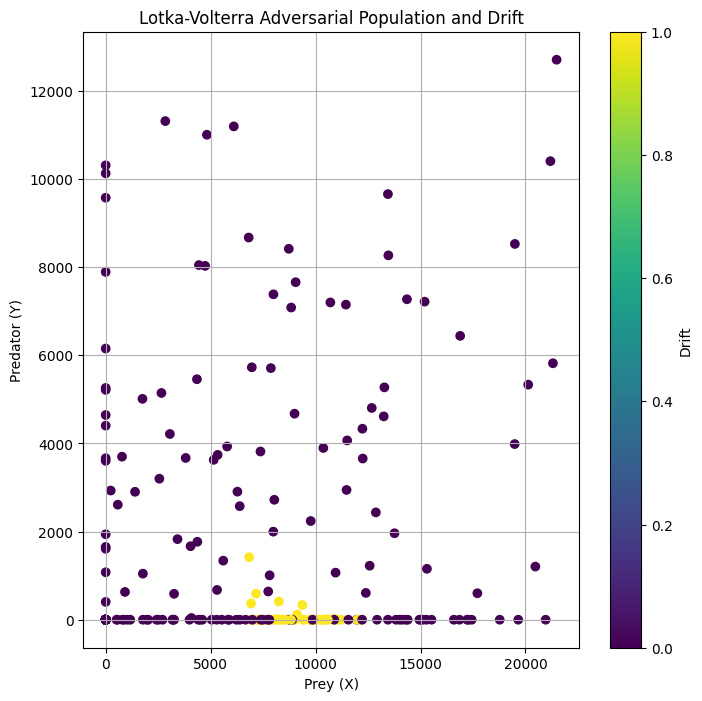

In [287]:
# Plotting the training history for Lotka-Volterra
fig_lv, ax_lv = plt.subplots(figsize=(10, 6))
ax_lv.plot(h_loss_lv, label="Loss")
ax_lv.set_yscale('log')
ax_lv_twin = ax_lv.twinx()
ax_lv_twin.plot(h_dmax_lv, label="Max Drift", c="r")
ax_lv.set_xlabel("Epoch")
ax_lv.set_ylabel("Loss (log scale)")
ax_lv_twin.set_ylabel("Max Drift")
fig_lv.legend(loc="upper right")
fig_lv.suptitle("Lotka-Volterra Training History")
plt.grid(True)
plt.show()


# Visualize the adversarial points for Lotka-Volterra (2D)
fig_lv_adv, ax_lv_adv = plt.subplots(figsize=(8, 8))
with torch.no_grad():
    drift_lv = get_drift(model_lv, net_lv, adv_lv.population).cpu().numpy()

points_lv = adv_lv.population.detach().cpu().numpy()

# 2D scatter plot for Lotka-Volterra
sc_lv = ax_lv_adv.scatter(
    points_lv[:, 0], points_lv[:, 1], c=drift_lv.flatten() > 0, cmap="viridis"
)
ax_lv_adv.set_xlabel("Prey (X)")
ax_lv_adv.set_ylabel("Predator (Y)")
ax_lv_adv.set_title("Lotka-Volterra Adversarial Population and Drift")

# Add colorbar
cbar_lv = plt.colorbar(sc_lv, ax=ax_lv_adv)
cbar_lv.set_label("Drift")
plt.grid(True)
plt.show()

In [ ]:
print("\n--- Lotka-Volterra Drift Heatmap ---")

# Define the grid for visualization
num_points = 500
prey_range = torch.linspace(0, 50_000, num_points)
predator_range = torch.linspace(0, 50_000, num_points)

# Create a meshgrid
prey_mesh, predator_mesh = torch.meshgrid(prey_range, predator_range, indexing='xy')

# Flatten and combine points for drift calculation
x_grid = torch.stack([prey_mesh.flatten(), predator_mesh.flatten()], dim=1).float()

# Calculate drift over the grid
with torch.no_grad():
    grid_drift = get_drift(model_lv, net_lv, x_grid).cpu().numpy()

# Reshape drift values back to grid format
drift_heatmap_data = grid_drift.reshape(num_points, num_points) / grid_drift.max()

# Create the heatmap plot
plt.figure(figsize=(10, 8))
plt.imshow(
    drift_heatmap_data.T,
    origin='lower',
    extent=[prey_range.min(), prey_range.max(), predator_range.min(), predator_range.max()],
    cmap='viridis',
    aspect='auto'
)

plt.colorbar(label='Drift Value')
# Add the adversarial points on top for context
points_lv = adv_lv.population.detach().cpu().numpy()
plt.scatter(points_lv[:, 0], points_lv[:, 1], c='red', s=5, alpha=0.5, label='Adversarial Points')

plt.xlabel('Prey (X)')
plt.ylabel('Predator (Y)')
plt.title('Lotka-Volterra Drift Landscape Heatmap')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
dist_contour = np.zeros_like(drift_heatmap_data.T)
for eps in np.logspace(-3, 1, 20):
    dist_contour += drift_heatmap_data.T * eps > eps - 1
plt.imshow(
    dist_contour,
    origin='lower',
    extent=[prey_range.min(), prey_range.max(), predator_range.min(), predator_range.max()],
    cmap='viridis',
    aspect='equal'
)
plt.xlabel('Prey (X)')
plt.ylabel('Predator (Y)')
plt.colorbar(label='probability bound')
plt.show()

# p53

In [18]:
class P53Oscillator(ReactionNetwork):
    def __init__(self):
        # Species Order: [p53, pMdm2, Mdm2]
        # 0 -> p53           [1, 0, 0]
        # p53 -> 0           [-1, 0, 0]
        # p53 -> p53+pMdm2   [0, 1, 0]
        # p53 -> 0 (alpha4)  [-1, 0, 0]
        # pMdm2 -> Mdm2      [0, -1, 1]
        # Mdm2 -> 0          [0, 0, -1]
        S = torch.tensor(
            [
                [1.0, 0.0, 0.0],
                [-1.0, 0.0, 0.0],
                [0.0, 1.0, 0.0],
                [-1.0, 0.0, 0.0],
                [0.0, -1.0, 1.0],
                [0.0, 0.0, -1.0],
            ]
        )
        super().__init__(S, self._propensities)

        # Parameters
        self.k1, self.k2, self.k3 = 90.0, 0.002, 1.7
        self.k4, self.k5, self.k6 = 1.1, 0.93, 0.96
        self.k7 = 0.01

    def _propensities(self, x):
        p53, pMdm2, Mdm2 = x[:, 0:1], x[:, 1:2], x[:, 2:3]

        return torch.cat(
            [
                torch.full_like(p53, self.k1),  # k1
                self.k2 * p53,  # k2
                self.k4 * p53,  # k4
                self.k3 * Mdm2 * (p53 / (p53 + self.k7)),
                self.k5 * pMdm2,  # k5
                self.k6 * Mdm2,  # k6
            ],
            dim=1,
        )


def p53_reference_g(x):
    # g(x) = 120*p53 + 0.2*pMdm2 + 0.1*Mdm2
    weights = torch.tensor([120.0, 0.2, 0.1], device=x.device)
    return torch.sum(weights * x, dim=1, keepdim=True)

In [27]:
net_p53 = P53Oscillator()

# Note: Using transition_center ~ 500 because the p53 scale is much larger here
model_p53, adv_p53, history_loss, history_max = train_tight_sets(
    net_p53,
    p53_reference_g,
    probability=None,
    n_species=3,
    steps_evolve=1,
    hidden_dim=512,
    n_adv_samples=2**10,
    n_rand_samples=2**14,  # 14,
    max_n=10_000,
    n_epochs=10_000,
    gamma=0.5,
    lr=1e-4,
    d_max_weight=0.01,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

Optimus interruptus


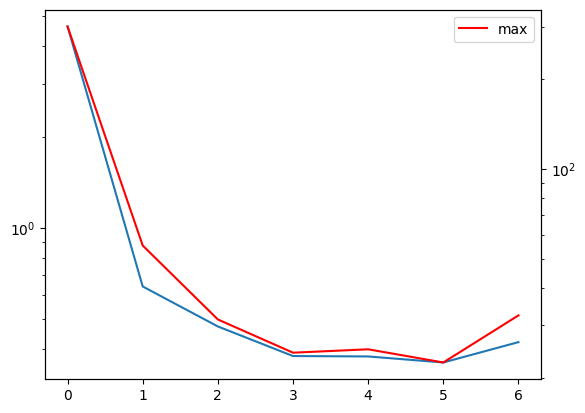

In [29]:
fig, ax = plt.subplots()
ax.plot(history_loss, label="loss")
tax = ax.twinx()
tax.plot(history_max, label="max", c="r")
tax.set_yscale('log')
ax.set_yscale('log')
plt.legend()

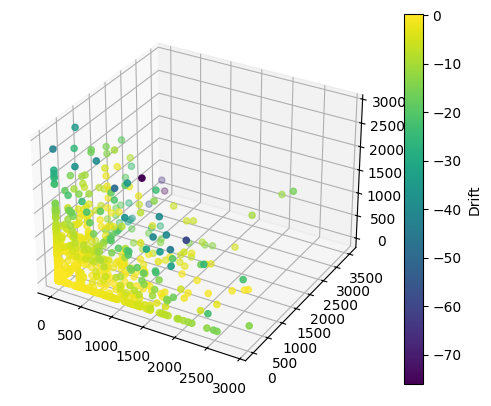

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

with torch.no_grad():
    drift = get_drift(model_p53, net_p53, adv_p53.population).numpy()

points = adv_p53.population.detach().numpy()

# Plot the point cloud and keep the mappable
sc = ax.scatter(
    points[:, 0], points[:, 1], points[:, 2], c=drift.flatten(), cmap="viridis"
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Drift")

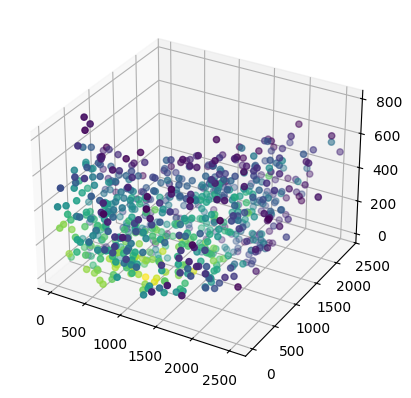

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

n=10000
points = eval_xs = torch.rand(n, 3) * torch.tensor([3000, 3000, 2000])
with torch.no_grad():
    drift = get_drift(model_p53, net_p53, points).numpy()

in_set = drift.flatten() / 10 * 1e-1 > 1e-1 - 1

drift = drift[in_set]
points = points[in_set]

# Plot the point cloud and keep the mappable
sc = ax.scatter(
    points[:, 0], points[:, 1], points[:, 2], c=drift , cmap="viridis"
)

# # Add colorbar
# cbar = plt.colorbar(sc, ax=ax)
# cbar.set_label("Drift")

In [80]:
!uv pip install "pyvista[jupyter]"

Resolved 110 packages in 172ms                                       
Prepared 4 packages in 535ms                                             
Installed 4 packages in 13ms                                
 + jupyter-server-proxy==4.4.0
 + simpervisor==1.0.0
 + trame-vtk==2.10.2
 + trame-vuetify==3.2.0


In [87]:
import pyvista as pv
import torch
import numpy as np
pv.set_jupyter_backend("trame")  # or "static"
plotter = pv.Plotter(notebook=True)
# Generate points
n = 100000
points = torch.rand(n, 3) * torch.tensor([5000, 5000, 5000])

with torch.no_grad():
    drift = get_drift(model_p53, net_p53, points)

# Move to NumPy
points_np = points.cpu().numpy()
drift_np = drift.cpu().numpy().flatten()

# Same mask as before
eps = .5
in_set = drift_np / 10 * eps > eps - 1

points_np = points_np[in_set]
drift_np = drift_np[in_set]

# Create PyVista point cloud
cloud = pv.PolyData(points_np)
cloud["drift"] = drift_np  # attach scalar data

# Plot
plotter = pv.Plotter()
plotter.add_points(
    cloud,add_points
    scalars="drift",
    cmap="viridis",
    point_size=5,
    render_points_as_spheres=True,
)
plotter.add_axes()
plotter.show()


Widget(value='<iframe src="http://localhost:40113/index.html?ui=P_0x7fdf9030f390_14&reconnect=auto" class="pyv…

In [19]:
import pandas as pd

In [16]:
n = 1_000_000
eval_xs = torch.rand(n, 3) * 10_000
with torch.no_grad():
    d_ref = get_drift(p53_reference_g, net_p53, eval_xs).numpy()
    d_aug = get_drift(model_p53, net_p53, eval_xs).numpy()

c_ref = np.max(d_ref)  # 10800.0
c_aug = max(np.max(d_aug), 35)

eps_list = [0.9, 0.1, 0.01, 0.001]
rows = []
for eps in eps_list:
    thresh = 1 - (1 / eps)
    count_ref = np.sum(d_ref / c_ref > thresh)
    count_aug = np.sum(d_aug / c_aug > thresh)
    rows.append(
        {
            "epsilon": eps,
            "ref_in_set": int(count_ref) / n,
            "aug_in_set": int(count_aug) / n,
        }
    )
print(c_ref, c_aug)
df_final = pd.DataFrame(rows)
df_final

11067.823 22


NameError: name 'pd' is not defined

(np.float32(153053.39), np.float32(13.986456))

In [168]:
for _ in tqdm.tqdm(range(100_000)):
    for _ in range(100_000):
    #     for _ in range(100_000):
            pass

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 